<a href="https://colab.research.google.com/github/mahtab2/Medical-Image-Segmentation/blob/main/Medical_image_segmentation_CVC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Preprequisites

In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
import json
from tqdm import tqdm
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Helper functions

In [27]:
def create_dir(path):
    # Create a directory.
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    # Read the image and mask from the given path.
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Data

In [ ]:
! mkdir data

## CVC

In [ ]:
!unrar x "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/PNG.rar" "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/PNG.rar

Creating    /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original  OK
Extracting  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original/1.png       0%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original/10.png       0%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original/100.png       0%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original/101.png       0%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original/102.png       0%  OK 
Extracting  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/Original/103.png       1%  OK 
Extracting  /content/drive/MyDrive/C

In [ ]:
! mkdir data/cvc

mkdir: cannot create directory ‘data/cvc’: File exists


In [ ]:
! mkdir /content/data/cvc/masks

In [ ]:
! mkdir /content/data/cvc/images

In [ ]:
! mv /content/drive/MyDrive/Colab\ Notebooks/vision/double-unet/data/cvc/Original/*.png /content/data/cvc/images

In [ ]:
! mv /content/drive/MyDrive/Colab\ Notebooks/vision/double-unet/data/cvc/Ground\ Truth/*.png /content/data/cvc/masks

Number of images for cvc

In [ ]:
! find /content/data/cvc/images -type f | wc -l

612


Number of masks for cvc

In [ ]:
! find /content/data/cvc/masks -type f | wc -l

612


# Pre Processing

## Augmentation

In [5]:
! pip install -U albumentations

     |████████████████████████████████| 102 kB 6.8 MB/s 
     |████████████████████████████████| 47.7 MB 1.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)
import albumentations as A

In [7]:
def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    crop_size = (192-32, 256-32)
    size = (512, 384)
    # size = (384, 288)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)
        x = cv2.resize(x, size)
        y = cv2.resize(y, size)
        # print(x.shape)
        # print(y.shape)

        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape

        if augment == True:

            ## Center Crop
            aug = A.CenterCrop(p=1.0, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = A.Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = A.RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = A.Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = A.GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = A.HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = A.VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = A.HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = A.CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = A.RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = A.RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = A.HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = A.RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = A.RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = A.RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = A.MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = A.MedianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']

            aug = A.GaussianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = A.GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = A.ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = A.CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)
            # print('inja', i.shape)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


## Split

In [8]:
def load_data(path, split=0.1):
    # Load all the data and then split them into train and valid dataset.
    img_path = glob(os.path.join(path, "images/*"))
    msk_path = glob(os.path.join(path, "masks/*"))

    img_path.sort()
    msk_path.sort()

    len_ids = len(img_path)
    train_size = int((90/100)*len_ids)
    valid_size = int((5/100)*len_ids)		## Here 10 is the percent of images used for validation
    test_size = int((5/100)*len_ids)		## Here 10 is the percent of images used for testing

    train_x, test_x = train_test_split(img_path, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(msk_path, test_size=test_size, random_state=42)

    train_x, valid_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [9]:
def split_augment_data(path,path2):
    np.random.seed(42)
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path2, split=0.1)

    create_dir(path + "/new_data1/train/image/")
    create_dir(path + "/new_data1/train/mask/")
    create_dir(path + "/new_data1/valid/image/")
    create_dir(path + "/new_data1/valid/mask/")
    create_dir(path + "/new_data1/test/image/")
    create_dir(path + "/new_data1/test/mask/")

    augment_data(train_x, train_y, path + "/new_data1/train/", augment=True)
    augment_data(valid_x, valid_y, path + "/new_data1/valid/", augment=False)
    augment_data(test_x, test_y, path + "/new_data1/test/", augment=False)

## CVC

In [ ]:
split_augment_data("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc","data/cvc")

  0%|          | 0/552 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1953: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
100%|██████████| 30/30 [00:00<00:00, 36.20it/s]


In [ ]:
! find /content/drive/MyDrive/Colab\ Notebooks/vision/double-unet/data/cvc/new_data1/train -type f | wc -l

28704


# PreParing data

In [11]:
def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([384, 512, 3])
    y.set_shape([384, 512, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

def prepare_train_data(train_path,valid_path,path):
    np.random.seed(42)
    tf.random.set_seed(42)
    create_dir(path + "/files")

    ## Training
    train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
    train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

    ## Shuffling
    train_x, train_y = shuffling(train_x, train_y)

    ## Validation
    valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
    valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

    return train_x,train_y, valid_x, valid_y

## cvc

In [12]:
train_x,train_y, valid_x, valid_y = prepare_train_data("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/new_data1/train/","/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/new_data1/valid/","/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc")

In [13]:
batch_size = 4

In [14]:
train_dataset = tf_dataset(train_x[:12757], train_y[:12757], batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

# Model

The double-unet model consists of two semi-unet networks as it is shown in the following diagram.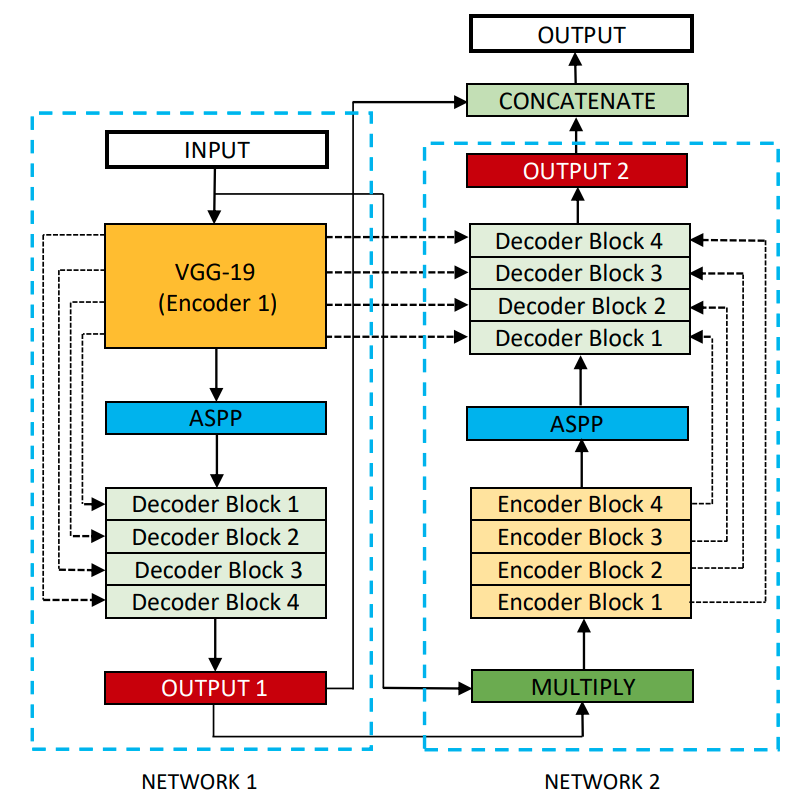

In [ ]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

# ===================================== Network 1 =============================================

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# ===================================== Network 2 =============================================

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

#=============================== double-unet Model ================================

def doubleunet_model(shape):
  # network 1
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)
    
  # input to the second network
    x = inputs * outputs1

  # network 2
    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    plot_model(model, to_file='segmentation_model.png', show_shapes=True, show_layer_names=True)
    return model


## Metrics

In [6]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# Train

In [15]:
model_base_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data"
epochs = 50
lr = 1e-4
shape = (384, 512, 3)

In [20]:
model = doubleunet_model(shape)

80150528/80134624 [==============================] - 0s 0us/step


In [30]:
def load_pretrained_model(path):
  metrics = [
        dice_coef,
        iou,
        Recall(),
        Precision()]
  model = tf.keras.models.load_model(path,custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou})
  model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
  return model

In [21]:
model = load_pretrained_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/files/"+"model5.h5")

In [22]:
def train_model(train_dataset,valid_dataset,train_x,valid_x,batch_size,epochs,path):
  callbacks = [
          ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/files/"+"model6.h5"),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
          CSVLogger("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/files/"+"data6.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
  ]

  train_steps = (len(train_x)//batch_size)
  valid_steps = (len(valid_x)//batch_size)

  if len(train_x) % batch_size != 0:
        train_steps += 1

  if len(valid_x) % batch_size != 0:
        valid_steps += 1

  model.fit(train_dataset,
              epochs=50,
              initial_epoch = 5,
              validation_data=valid_dataset,
              steps_per_epoch=train_steps,
              validation_steps=valid_steps,
              callbacks=callbacks,
              verbose=1,
              shuffle=False)
  return model

## cvc

In [23]:
len(train_x)

14352

In [ ]:
model_cvc = train_model(train_dataset,valid_dataset,train_x,valid_x,4,epochs,"/cvc/files/")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 6/50
3588/3588 [==============================] - 9474s 3s/step - loss: 0.1287 - dice_coef: 0.8713 - iou: 0.7853 - recall: 0.8022 - precision: 0.9138 - val_loss: 0.1542 - val_dice_coef: 0.8458 - val_iou: 0.7401 - val_recall: 0.7095 - val_precision: 0.9614 - lr: 1.0000e-04
Epoch 7/50
3588/3588 [==============================] - 3758s 1s/step - loss: 0.1161 - dice_coef: 0.8839 - iou: 0.8039 - recall: 0.8163 - precision: 0.9234 - val_loss: 0.4267 - val_dice_coef: 0.5733 - val_iou: 0.4078 - val_recall: 0.3973 - val_precision: 0.9747 - lr: 1.0000e-04
Epoch 8/50
3588/3588 [==============================] - 3747s 1s/step - loss: 0.0984 - dice_coef: 0.9016 - iou: 0.8302 - recall: 0.8397 - precision: 0.9359 - val_loss: 0.2868 - val_dice_coef: 0.7132 - val_iou: 0.5660 - val_recall: 0.6091 - val_precision: 0.9324 - lr: 1.0000e-04
Epoch 9/50
3588/3588 [==============================] - 3756s 1s/step - loss: 0.0947 - dice_coef: 0.9053 - iou: 0.8360 - recall: 0.8428 - precision: 0.9392 - val_l

In [ ]:
model_cvc = train_model(train_dataset,valid_dataset,train_x,valid_x,8,epochs,"/cvc/files/")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 3/50
1794/1794 [==============================] - 8707s 5s/step - loss: 0.2328 - dice_coef: 0.7672 - iou: 0.6394 - recall: 0.7083 - precision: 0.8362 - val_loss: 0.1484 - val_dice_coef: 0.8516 - val_iou: 0.7485 - val_recall: 0.7637 - val_precision: 0.9415 - lr: 1.0000e-04
Epoch 4/50
1014/1794 [===============>..............] - ETA: 1:02:08 - loss: 0.1957 - dice_coef: 0.8043 - iou: 0.6888 - recall: 0.7376 - precision: 0.8642

In [ ]:
model_cvc = train_model(train_dataset,valid_dataset,train_x,valid_x,4,epochs,"/cvc/files/")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
3588/3588 [==============================] - 10470s 3s/step - loss: 0.5103 - dice_coef: 0.4897 - iou: 0.3454 - recall: 0.7216 - precision: 0.4684 - val_loss: 0.3618 - val_dice_coef: 0.6382 - val_iou: 0.4814 - val_recall: 0.6403 - val_precision: 0.7127 - lr: 1.0000e-04
Epoch 2/50
2721/3588 [=====================>........] - ETA: 14:58 - loss: 0.2234 - dice_coef: 0.7766 - iou: 0.6518 - recall: 0.7177 - precision: 0.8448

# Prediction

In [23]:
test_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/new_data1/test/"

In [24]:
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))

In [17]:
model = load_pretrained_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/files/"+"model5.h5")

In [28]:
def evaluating_model(test_x, test_y):
    np.random.seed(42)
    tf.random.set_seed(42)

    batch_size = 1

    print(len(test_x))
    test_dataset = tf_dataset(test_x, test_y)

    test_steps = (len(test_x)//batch_size)
    if len(test_x) % batch_size != 0:
        test_steps += 1

    # model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/lesion/files/"+"model3.h5",custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef,'iou':iou}, compile=False)
    print("evaluate")
    model.evaluate(test_dataset, steps=test_steps)


In [29]:
evaluating_model(test_x, test_y)

30
evaluate
30/30 [==============================] - 1522s 50s/step - loss: 0.0869 - dice_coef: 0.9131 - iou: 0.8407 - recall: 0.8410 - precision: 0.9558


# Visualisation

In [31]:
#@title Load model and test set
test_path = "/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/new_data1/test/"
test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
model = load_pretrained_model("/content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/files/"+"model5.h5")


path is :  /content/drive/MyDrive/Colab Notebooks/vision/double-unet/data/cvc/new_data1/test/image/100_0.jpg


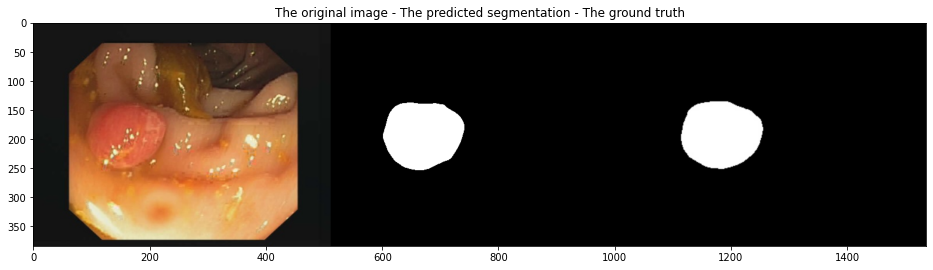

In [35]:
#@title Segment an image
import sklearn
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

size = (512, 384)

def preprocessing(img):
    size = (512, 384)
    img2 = cv2.resize(img, size)
    img2 = np.clip(img2 - np.median(img2)+127, 0, 255)
    img2 = img2.astype(np.float32)

    img2 = img2/255.
    return img2


def get_predict(model, img):
    processed_img = preprocessing(img)
    processed_img = np.expand_dims(processed_img, axis=0)
    out_put = model.predict(processed_img)
    out_put = out_put[..., -1]
    out_put = out_put[0]
    out_put = sklearn.preprocessing.binarize(out_put, threshold=0.5)
    out_put = out_put*255.
    return out_put

#@markdown Choose a number between 1 to 30
index =  1#@param {type:"integer"}

x = test_x[index-1]
y = test_y[index-1]
print("path is : ", x)
img2 = cv2.imread(x, cv2.IMREAD_COLOR)
groundthruth = cv2.imread(y, cv2.IMREAD_COLOR)
out_put = get_predict(model, img2)
out_put = out_put.astype(np.uint8)
out_put = np.stack([out_put, out_put, out_put], axis=-1)
out_put2 = np.concatenate([cv2.resize(img2, size), out_put, groundthruth], axis=1)
# cv2_imshow(out_put2)
plt.figure(figsize=(16, 8))
plt.title("The original image - The predicted segmentation - The ground truth")
plt.imshow(cv2.cvtColor(out_put2, cv2.COLOR_BGR2RGB))